In [1]:
import os
import sys
import yaml
import json
import warnings
import numpy as np
import pandas as pd
import gurobipy as gp
from analysis import analysis
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

In [2]:
n_scenario = 16
num_scenario = '/' + str(n_scenario) + '_Scenario/'
sys.path.append("/Users/ashutoshshukla/Desktop/TwoStageModel/")

In [3]:
from utils import prepare_input
from main_model import two_stage_model

pd.options.display.max_seq_items = 200
pd.set_option('display.width', 100)
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 50)
warnings.filterwarnings("ignore")

%matplotlib inline

In [4]:
model_analysis = analysis(16,"rm_")

In [5]:
with open(r'../config.yaml') as file:
    model_params = yaml.load(file, Loader=yaml.FullLoader)

model_params["path_to_input"] = '/Users/ashutoshshukla/Desktop/Data/fixed_reduced_grid' + num_scenario
model_params["input1"], model_params["input2"] = prepare_input(model_params["path_to_input"])

print("MIP-Gap: ", model_params["mip_gap"])
print("Time Limit: ", model_params["time_limit"])
print("Robust Model: ", model_params["robust_flag"])
print("Flexible Generation: ", model_params["flexible_generation"])
print("Objective Type:\t", model_params["set_objective"], "\n")
print("Solver Method:\t", model_params["solver_method"], "\n")

MIP-Gap:  0.005
Time Limit:  21600
Robust Model:  False
Flexible Generation:  True
Objective Type:	 min 

Solver Method:	 2 



In [7]:
for i in model_analysis.main_df.columns:
    fix = 0
    var = 0
    
    for j in model_analysis.base_model.unique_substations:
        temp = model_analysis.main_df.loc[j,i]
        
        if temp > 0:
            fix = fix + 1
            var = var + temp
        bud = 25000*fix + 100000*var
    print(bud/1e6)

0.0
9.925
19.925
29.975
39.975
50.0
59.95
69.925
72.45


In [ ]:
budget_vector = [0,10,20,30,40,50,60,70,80]

for budget in budget_vector:
    print (budget)
    print("\n\n*********************************************")
    print("*********************************************\n\n")
    
    
    base_model = two_stage_model(model_params)
    base_model.budget_ref.rhs = budget*1e6
    for i in model_analysis.base_model.unique_substations:
        base_model.model.addConstr(base_model.x[i] == round(model_analysis.main_df.loc[i,budget]))
    
    base_model.model.setParam("MIPGap", model_params["mip_gap"])
    base_model.model.setParam("TimeLimit", model_params["time_limit"])
    base_model.model.setParam("Method", model_params["solver_method"])
    base_model.model.optimize()
    
    print("\n\n*********************************************")
    print("*********************************************\n\n")

# Wait and see and the robust bound

In [8]:
df = pd.read_csv(os.path.dirname(os.getcwd()) + "/output/sm_" + str(n_scenario) + "/stochastic_solution.csv")
stochastic_solution = {}

for i in range(df.shape[0]):
    stochastic_solution[df.iloc[i,0]] = df.iloc[i,1]

In [9]:
df_r = pd.read_csv(os.path.dirname(os.getcwd()) + "/output/rm_" + str(n_scenario) + "/robust_solution.csv")
robust_solution = {}

for i in range(df_r.shape[0]):
    robust_solution[df_r.iloc[i,0]] = df_r.iloc[i,1]

In [10]:
df_rb = pd.read_csv(os.path.dirname(os.getcwd()) + "/output/rm_" + str(n_scenario) + "/robust_decisions_stochastic_solutions.csv")
robust_bound = {}

for i in range(df_rb.shape[0]):
    robust_bound[df_rb.iloc[i,0]] = df_rb.iloc[i,1]

In [11]:
import json
with open('wait_and_see_dict.json', 'r') as openfile:
    wait_and_see_dict = json.load(openfile)

wait_and_see_bound = {}
for i in wait_and_see_dict:
    temp = 0
    for j in wait_and_see_dict[i]:
        temp = temp + wait_and_see_dict[i][j]
    temp = temp/len(wait_and_see_dict[i])
    wait_and_see_bound[i] = temp

In [12]:
budget_vector = [0,10,20,30,40,50,60,70,80]

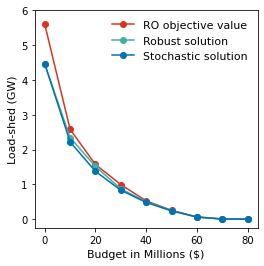

In [25]:
load = model_params["input1"]["load"].sum()

ss = [x/10 for x in list(stochastic_solution.values())]
rs = [x/10 for x in list(robust_solution.values())]

rb = [x/10 for x in list(robust_bound.values())]

wsb = [x/10 for x in list(wait_and_see_bound.values())]

plt.figure(figsize=(4,4))

plt.plot(budget_vector, rs, marker='o', label = "RO objective value", color="#DC3220")
plt.plot(budget_vector, rb, marker='o', label = "Robust solution", color="#40B0A6")
plt.plot(budget_vector, ss, marker='o', label = "Stochastic solution", color="#0072b2")
#plt.plot(budget_vector, wsb, marker='o', label = "Wait-and-see solution", color="#d55e00")

plt.xlabel("Budget in Millions ($)", fontdict={'fontsize': 11})
plt.ylabel("Load-shed (GW)", fontdict={'fontsize': 11})
plt.legend(loc=1, prop={'size': 11}, frameon=False)
plt.ylim(-0.25,6)

plt.savefig(os.path.dirname(os.getcwd()) + "/Figures/robust_decision_bounds.eps", format='eps')